# Plane's Windows

#### This exercices aims to build an algorithm to detect windows which are abnormal.

1/ With this information and no more, formulate the problem, and tell him what is feasible and what is not.

2/ Develop an approach to answer his question in the best way possible.

3/ Present your findings to the expert, in a way he can understand and help you validate your results...

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [36]:
data = pd.read_csv("./data/dataset.csv")

df = data.drop(columns=["day_cycle_window"])

print(list(data["day_cycle_window"])[-1])

4_4_160


In [26]:
def plotAnomalyScore2D(df, clf_name, clf, n):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df)
    
    for col in df.columns :
        fig = plt.figure()
        plot = plt.scatter(x=range(n), y=df[col], marker='.', c=-score, cmap='Reds')
        plt.colorbar(plot, label='anomaly score')
        plt.xlabel("Samples")
        plt.ylabel("Values")
        plt.title(clf_name + "\n" + col)

### Graphes des échantillons pour chacune des variables

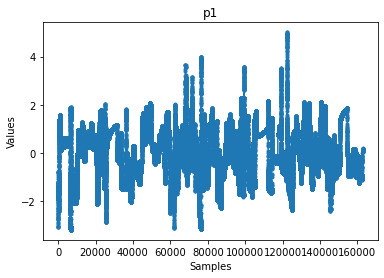

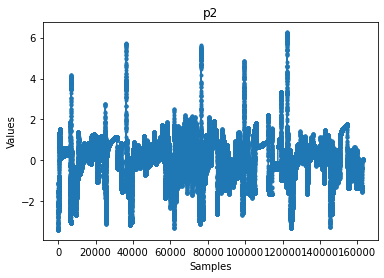

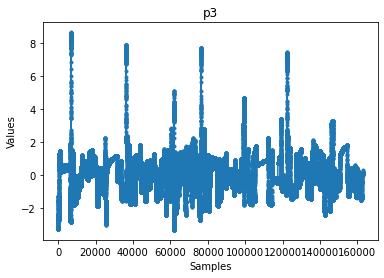

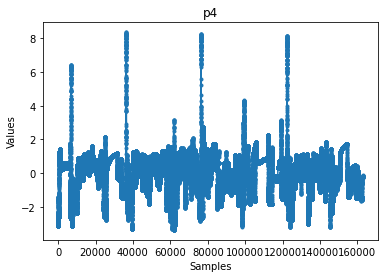

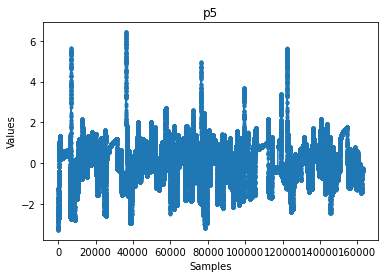

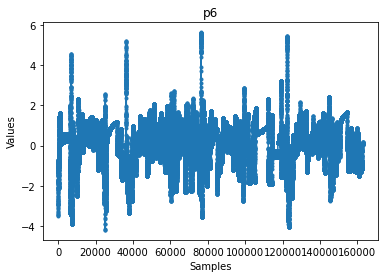

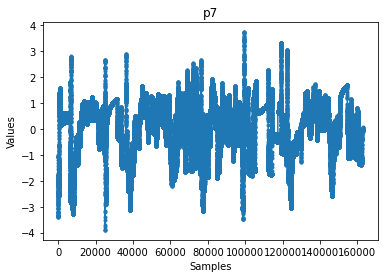

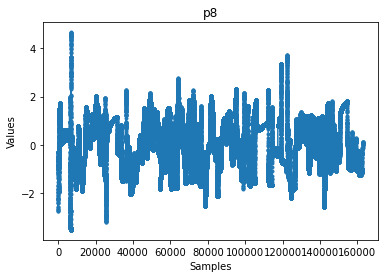

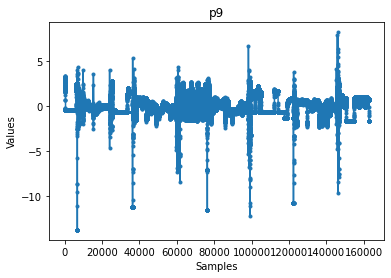

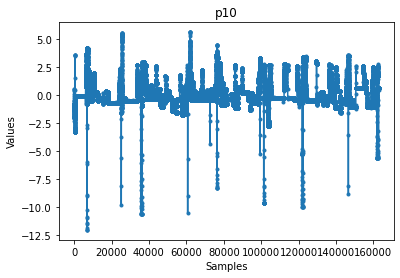

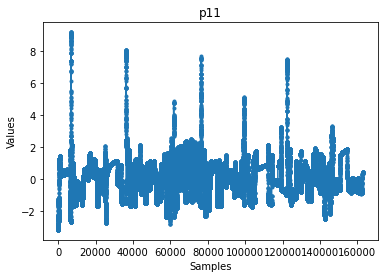

In [8]:
for col in df.columns :
    fig = plt.figure()
    plt.plot(df[col], marker='.')
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.title(col)

# Etude de toutes les données d'un coup

# Méthodes Outliers

### Distance de Mahalanobis

In [9]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df)

EllipticEnvelope(contamination=0.15)

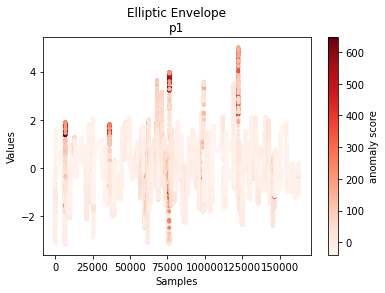

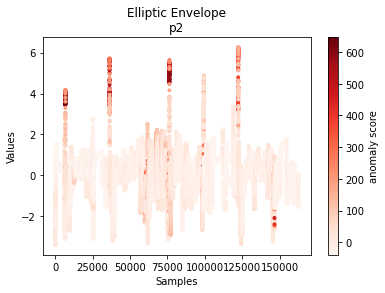

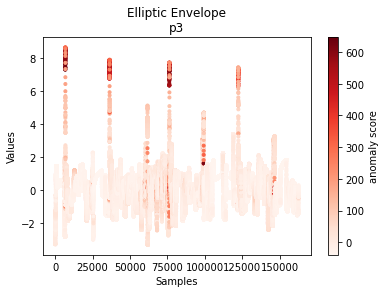

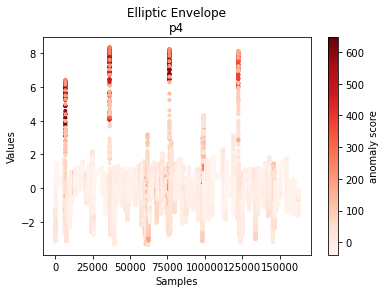

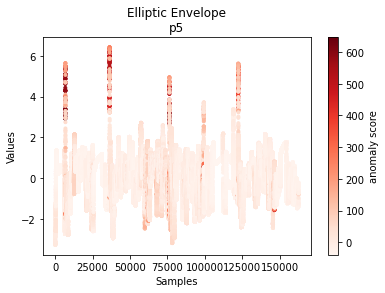

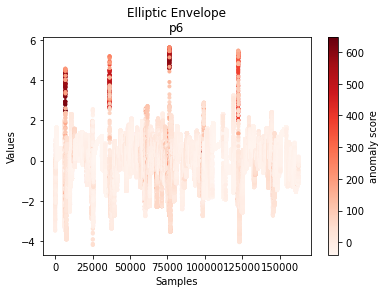

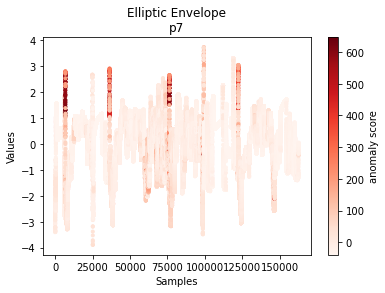

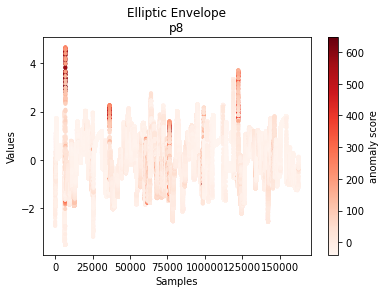

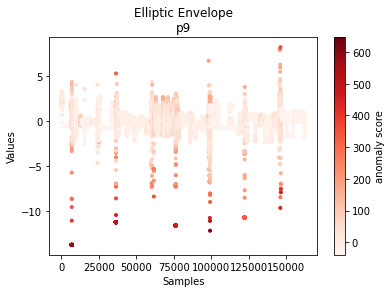

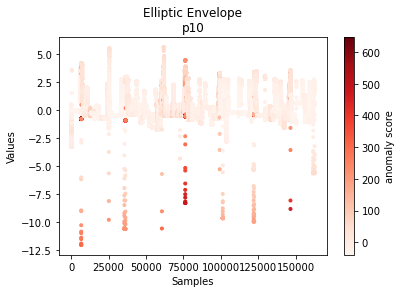

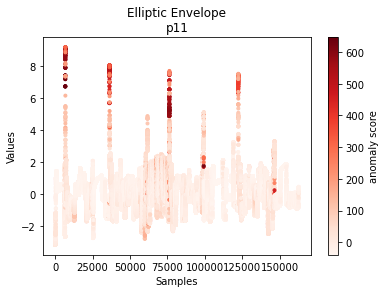

In [10]:
n = df.shape[0]

plotAnomalyScore2D(df, clf_name, clf, n)

### Méthode d'Isolation Forest

In [37]:
clf_name = 'Isolation Forest'
clf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.05)
clf.fit(df)

/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


IsolationForest(behaviour='new', contamination=0.05)

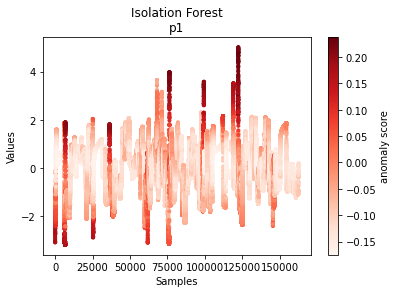

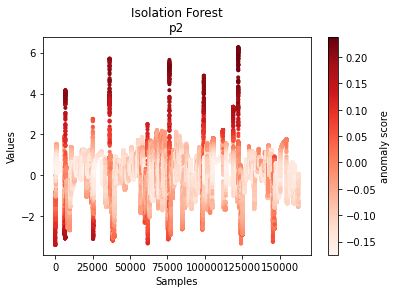

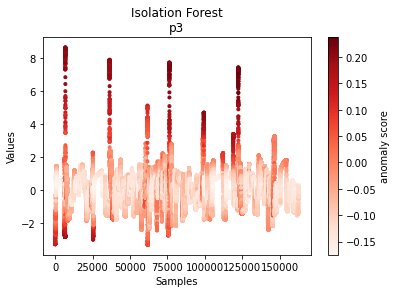

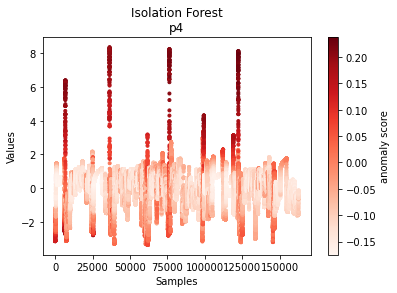

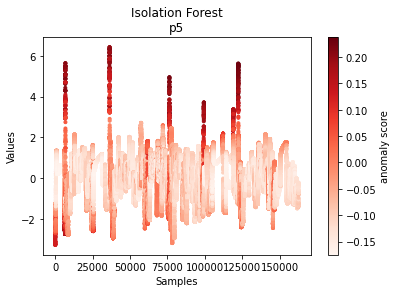

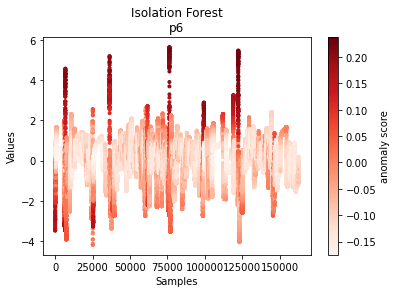

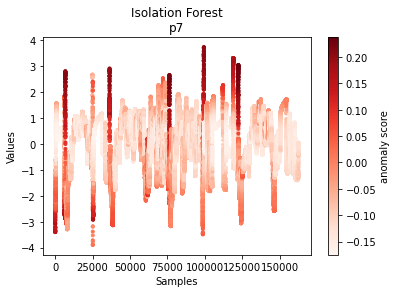

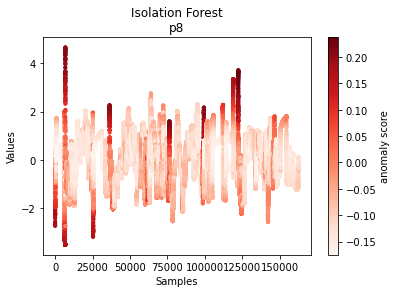

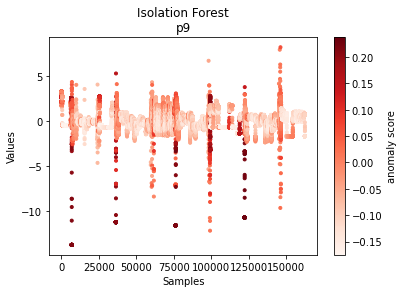

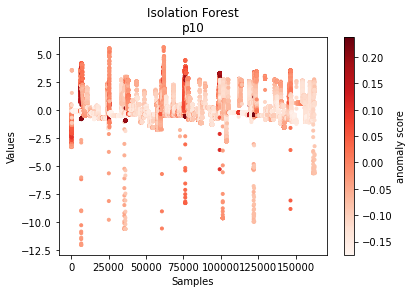

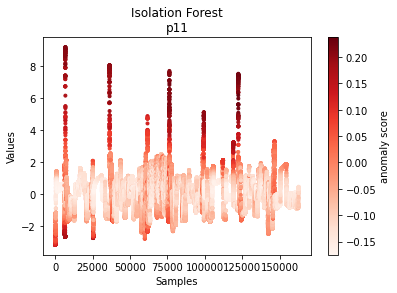

In [38]:
n = df.shape[0]

plotAnomalyScore2D(df, clf_name, clf, n)

# Etude des données jour par jour

In [18]:
def window(day, cycle, window):
    string = str(day) + '_' + str(cycle) + '_' + str(window)
    data_window = data[data["day_cycle_window"] == string]
    return data_window.drop(columns=["day_cycle_window"])

In [27]:
data_1_1_1 = window(1,1,1)

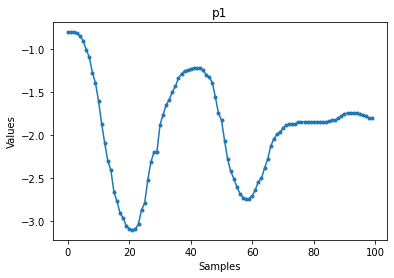

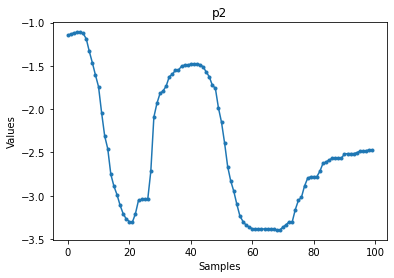

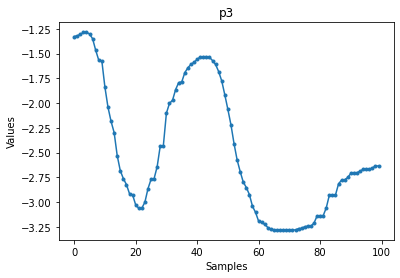

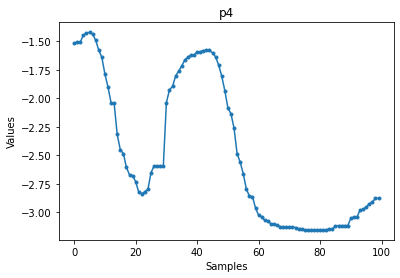

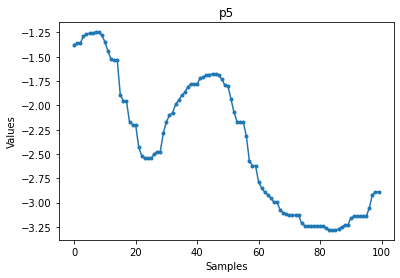

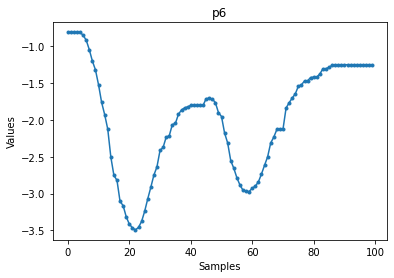

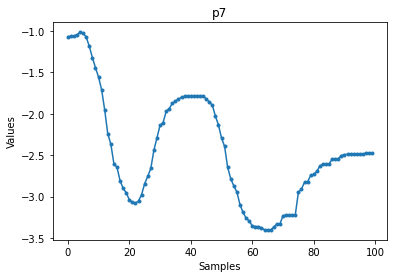

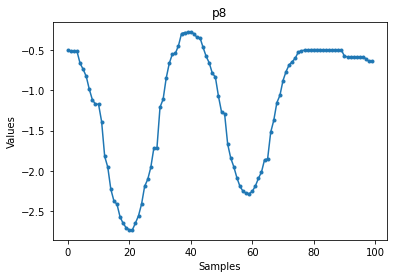

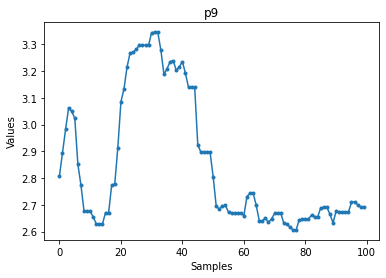

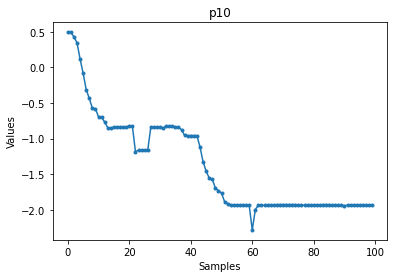

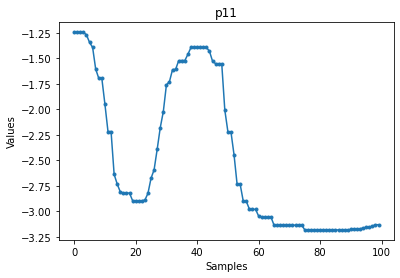

In [20]:
for col in data_1_1_1.columns :
    fig = plt.figure()
    plt.plot(data_1_1_1[col], marker='.')
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.title(col)

In [22]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(data_1_1_1)

EllipticEnvelope(contamination=0.15)

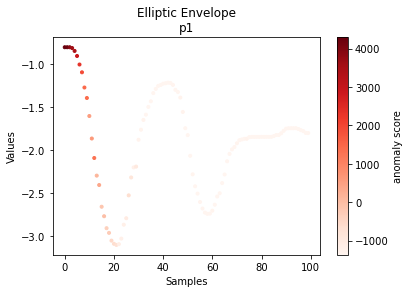

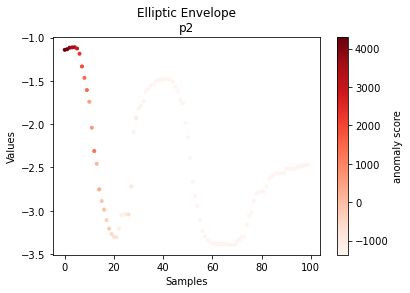

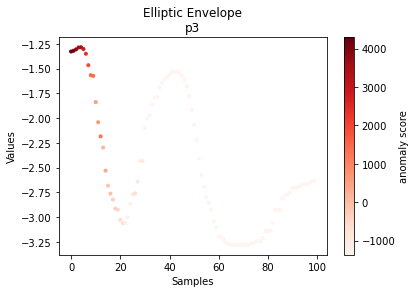

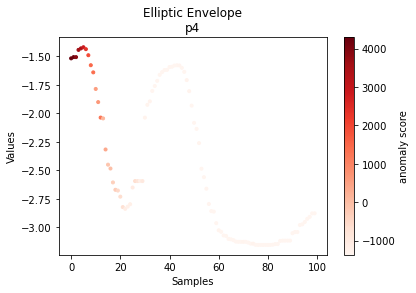

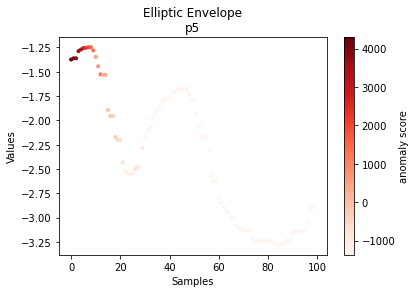

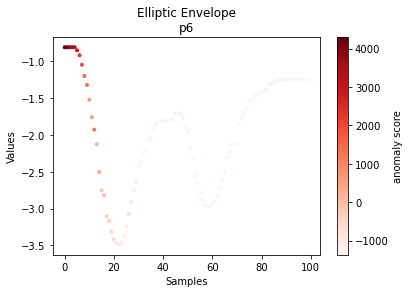

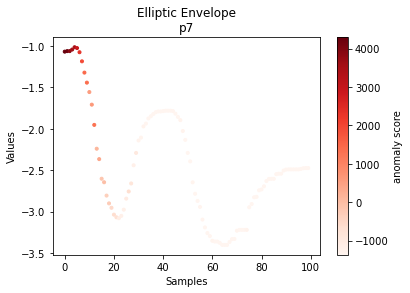

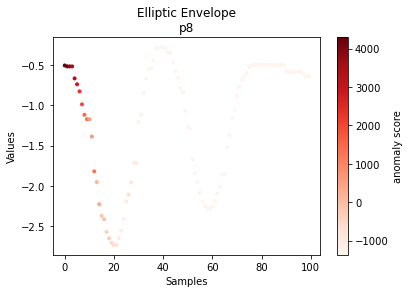

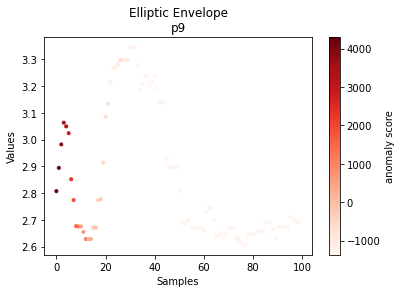

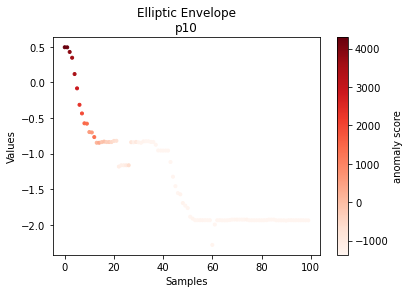

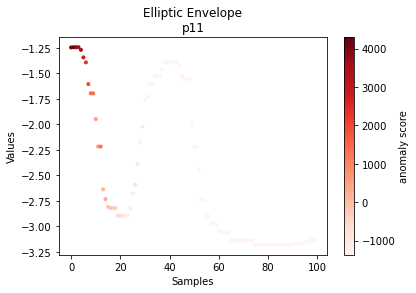

In [28]:
n = data_1_1_1.shape[0]

plotAnomalyScore2D(data_1_1_1, clf_name, clf, n)

In [31]:
clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.3) # nu corresponds to contamination
clf.fit(data_1_1_1)

OneClassSVM(gamma=0.3, nu=0.05)

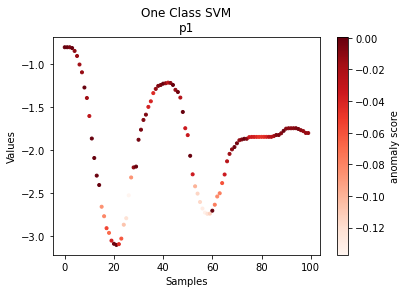

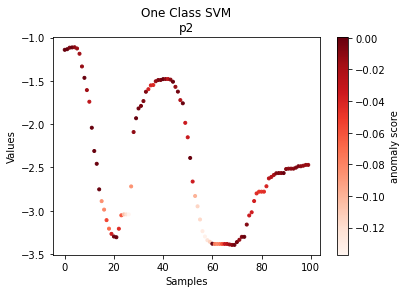

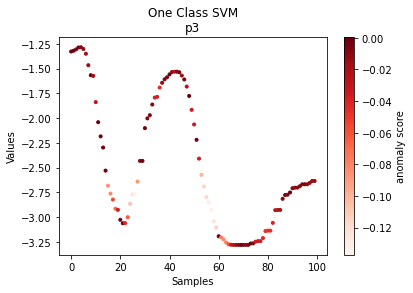

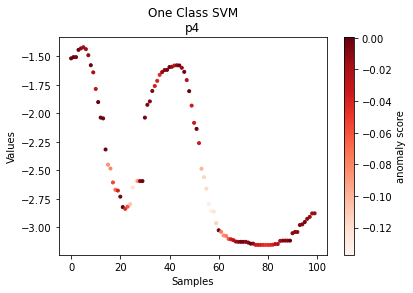

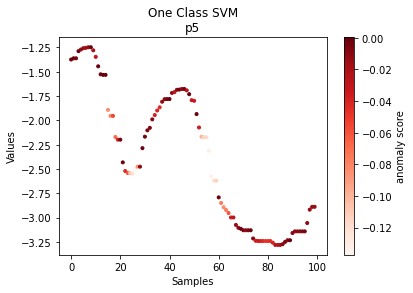

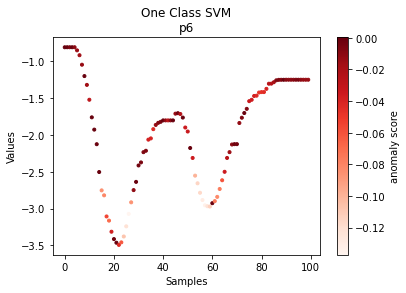

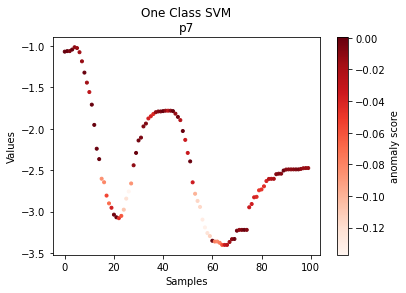

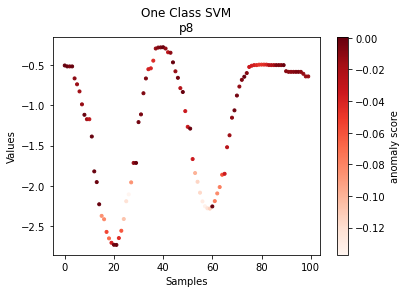

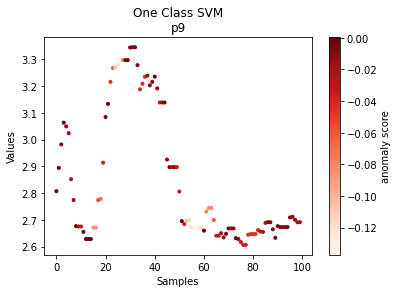

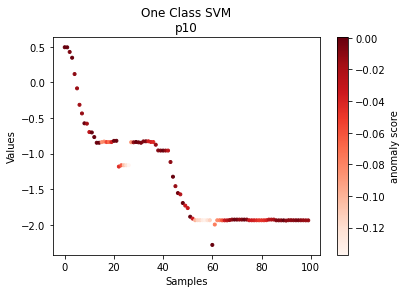

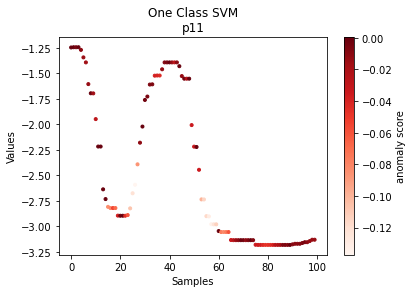

In [32]:
n = data_1_1_1.shape[0]

plotAnomalyScore2D(data_1_1_1, clf_name, clf, n)

#### Tentative de ACP

In [57]:
from sklearn.decomposition import PCA
import numpy

(162702, 11)
[6.78471289 1.38338762 0.5530044  0.46864381 0.41509546 0.39832597
 0.31423007 0.23343765 0.21194166 0.1624693  0.06846175]


<BarContainer object of 11 artists>

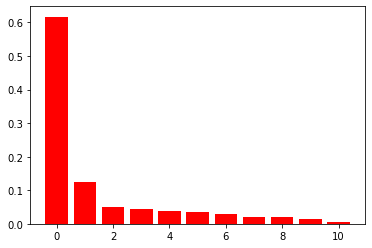

In [61]:
print(df.shape)

df_pca = PCA()
df_pca.fit(df)

print(df_pca.explained_variance_)

plt.bar(range(df.shape[1]), df_pca.explained_variance_ratio_, color="r", align="center")

[[ 0.78712433  0.08569477 -0.1951763   0.3569533   0.36542504  0.22461282
   0.05164051 -0.05309631  0.11354922  0.07031622  0.01285654]
 [ 0.89944914  0.09113868 -0.1471871   0.10900854  0.04406859 -0.00843408
  -0.05263732  0.0691715  -0.24070967 -0.28518515 -0.01191752]
 [ 0.81990439 -0.4177894   0.10734309  0.04803718  0.06175614 -0.30538318
   0.04520576  0.07984366  0.04683408  0.00498755  0.17772072]
 [ 0.86766217  0.08806605  0.08593643  0.19030307 -0.22070371 -0.08808055
   0.03390787 -0.27275952 -0.20197125  0.15092819 -0.00798371]
 [ 0.85493591  0.00737819 -0.07514533  0.05347118 -0.23027409 -0.01312223
  -0.39122251 -0.04192153  0.22413748 -0.04347534 -0.01747237]
 [ 0.83357278  0.20978411 -0.06131867 -0.07154983 -0.24146202  0.02699785
   0.38180823 -0.02527828  0.18801431 -0.10487587 -0.01776959]
 [ 0.83607101  0.30248576 -0.15236829 -0.10311715 -0.13502091  0.11983222
  -0.01962832  0.31298286 -0.09415448  0.18791927  0.02050585]
 [ 0.78100653  0.03848196 -0.20722329 -0.

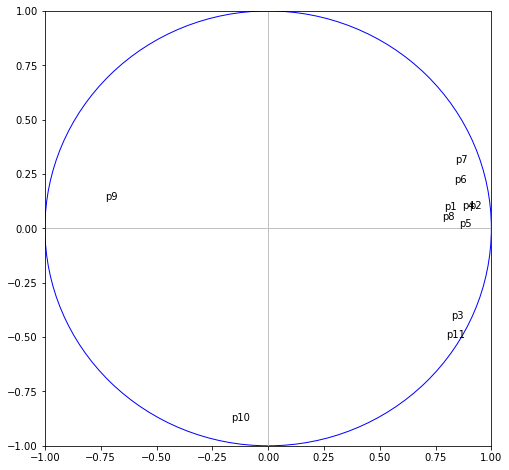

In [63]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

#Matrice de covariance
corvar = numpy.zeros((df.shape[1],df.shape[1]))

#Valeurs propres
eigval = (n-1)/n*df_pca.explained_variance_


sqrt_eigval = numpy.sqrt(eigval)
for k in range(df.shape[1]):
     corvar[:,k] = df_pca.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(corvar)

#affichage des étiquettes (noms des variables)
for j in range(df.shape[1]):
    plt.annotate(df.columns[j],(corvar[j,0],corvar[j,1]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()